## Семинар 4: "Сверточные сети"

ФИО: Филин Максим Дмитриевич

In [2]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/home/maksim/Remote/venv36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
torch.cuda.is_available()

True

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [4]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    for i in range(len(signal_convolved)):
        signal_convolved[i] = (signal[i:i+len(kernel)]*kernel[::-1]).sum()
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [5]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

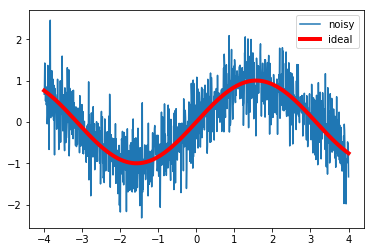

In [11]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [12]:
denoised_signal = t_convolve(noisy_signal, np.array([0.2,0.2,0.2,0.2,0.2]))

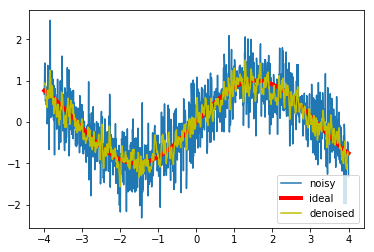

In [13]:
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

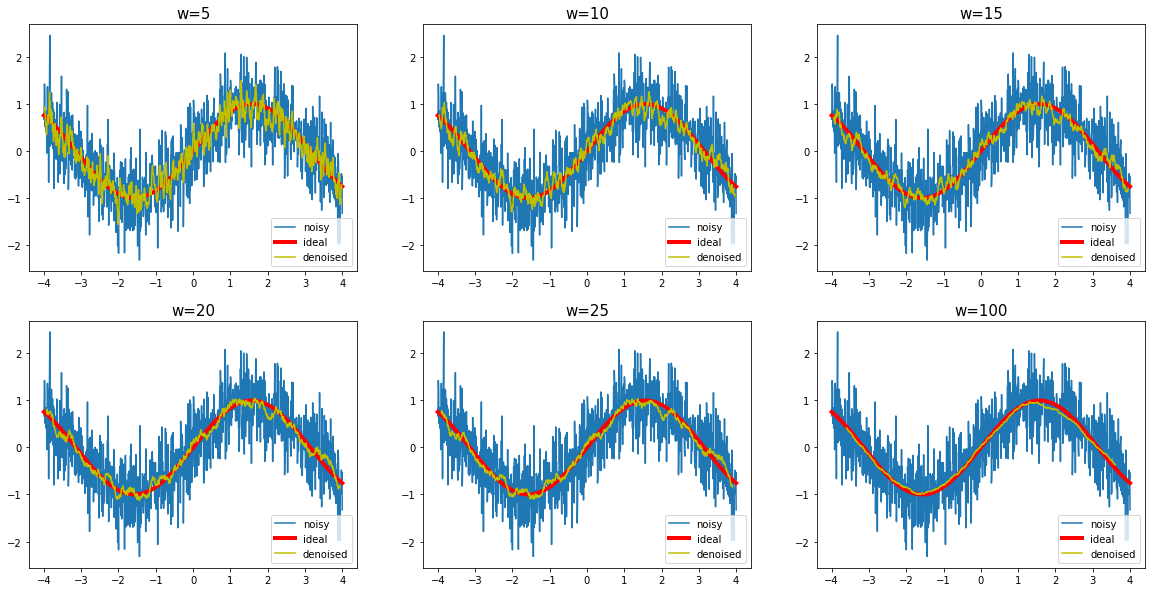

In [32]:
plt.figure(figsize=(20, 10))
for i, w in enumerate([5, 10, 15, 20, 25, 100]):
    plt.subplot(2, 3, i+1)
    kernel = np.array([1./w]*w)
    denoised_signal = t_convolve(noisy_signal, kernel)
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=4)

    plt.plot(x[int(w/2):len(denoised_signal) + int(w/2)], denoised_signal, 'y', label='denoised')
    plt.title('w={}'.format(w), fontsize=15)
    plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

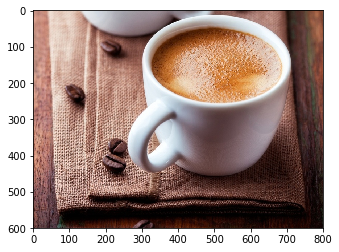

In [35]:
image = plt.imread('image.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [50]:
color_to_bw = np.array([0.299, 0.587, 0.114]).reshape(1, 1, -1)

In [51]:
color_to_bw

array([[[0.299, 0.587, 0.114]]])

In [52]:
color_to_bw.shape, image.shape

((1, 1, 3), (600, 800, 3))

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

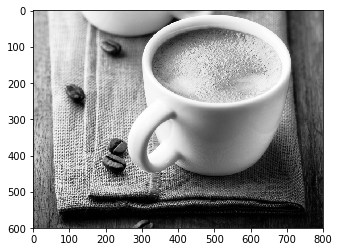

In [54]:
bw_image = convolve(image, color_to_bw[:, :, ::-1], mode='valid')[:, :, 0]
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [60]:
Kx = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
Ky = Kx.T
Kx = Kx.reshape(3, 3, 1)
Ky = Ky.reshape(3, 3, 1)
Gx = convolve(image, Kx, mode='valid').sum(2)
Gy = convolve(image, Ky, mode='valid').sum(2)
Gx.shape

(598, 798)

Text(0.5,1,'|[Gx, Gy]|')

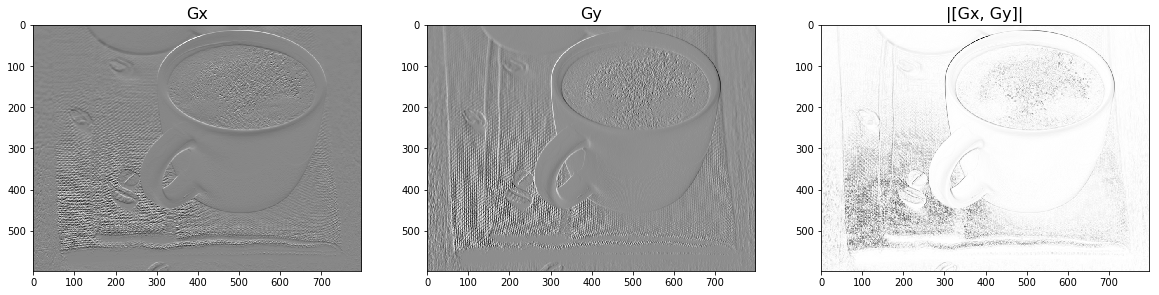

In [61]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(Gx, cmap=plt.cm.Greys)
plt.title('Gx', fontsize=16)
plt.subplot(1, 3, 2)
plt.imshow(Gy, cmap=plt.cm.Greys)
plt.title('Gy', fontsize=16)

edges = np.sqrt(Gx**2+Gy**2)
plt.subplot(1, 3, 3)
plt.imshow(edges, cmap=plt.cm.Greys)
plt.title('|[Gx, Gy]|', fontsize=16)

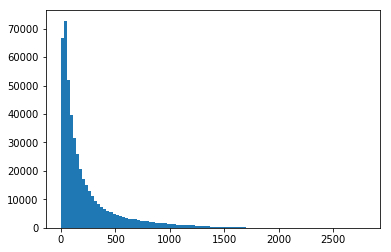

In [44]:
plt.hist(edges.ravel(), bins=100)
plt.show()

Text(0.5,1,'TH=500')

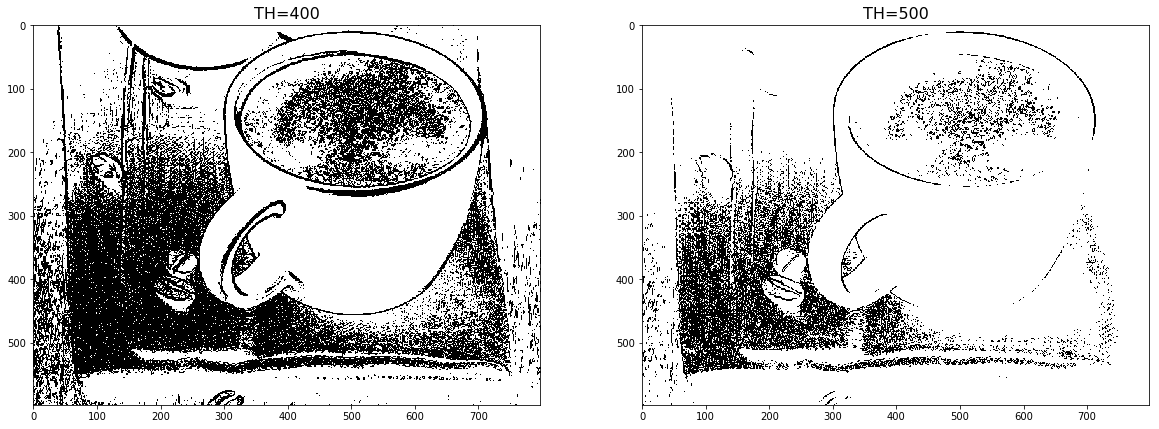

In [45]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(edges > 200, cmap=plt.cm.Greys)
plt.title('TH=400', fontsize=16)
plt.subplot(1, 2, 2)
plt.imshow(edges > 500, cmap=plt.cm.Greys)
plt.title('TH=500', fontsize=16)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

In [49]:
image.shape

(600, 800, 3)

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [48]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    for i in range(len(signal_convolved)):
        signal_convolved[i] = (signal[i:i+len(kernel)]*kernel[::-1]).sum()
    return signal_convolved

In [101]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    ##### YOUR CODE HERE #####
    print(kernel.ndim)
    signal_convolved = np.zeros((signal.shape[0], signal.shape[1], kernel.ndim))
    for k in range(kernel.ndim):
        signal_convolved[:,:,k] = convolve(signal, kernel[:, :, :, k], mode='valid').sum(2)
    return signal_convolved

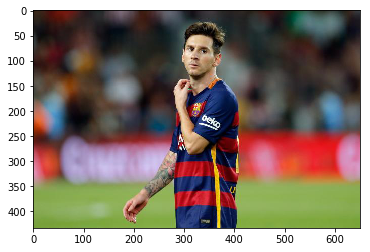

In [102]:
image = plt.imread('messi.jpg')
plt.imshow(image)

In [103]:
t_convolve_bank(image, kernel).shape

4


(433, 650, 4)

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [107]:
# ядро перевернется в convolve
kernel = np.array([[1, 0, 0, 1],                           #R
                  [0, 1, 0, 1],                            #G
                  [0, 0, 1, 1]]).reshape(1, 1, 3, 4)       #B
kernel, kernel.shape

(array([[[[1, 0, 0, 1],
          [0, 1, 0, 1],
          [0, 0, 1, 1]]]]), (1, 1, 3, 4))

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

4


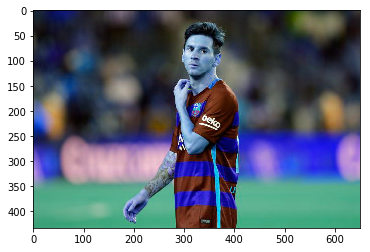

In [108]:
##### YOUR CODE HERE #####
plt.imshow(t_convolve_bank(image, kernel)[:,:,0:3].astype(np.uint8))
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [148]:
image = plt.imread('messi.jpg')
image.shape

(433, 650, 3)

In [149]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    if image.shape[0] % 2 != 0:
        a = np.zeros((1, image.shape[1], image.ndim))
        image = np.concatenate((image, a), axis=0)
    if image.shape[1] % 2 != 0:
        a = np.zeros((image.shape[0], 1, image.ndim))
        image = np.concatenate((image, a), axis=1)
        
    reduced_image = np.zeros((int(image.shape[0] / w), int(image.shape[1] / w), image.ndim))
    
    quoters1 = image[::2, ::2, :]
    quoters2 = image[1::2, ::2, :]
    quoters3 = image[::2, 1::2, :]
    quoters4 = image[1::2, 1::2, :]
    
    for quoter in (quoters1, quoters2, quoters3, quoters4):
        reduced_image = np.maximum(reduced_image, quoter)
    return reduced_image

def medianpool(image, w=2):
    assert(image.ndim == 3)
    if image.shape[0] % 2 != 0:
        a = np.zeros((1, image.shape[1], image.ndim))
        image = np.concatenate((image, a), axis=0)
    if image.shape[1] % 2 != 0:
        a = np.zeros((image.shape[0], 1, image.ndim))
        image = np.concatenate((image, a), axis=1)
    quoters1 = image[::2, ::2, :]
    quoters2 = image[1::2, ::2, :]
    quoters3 = image[::2, 1::2, :]
    quoters4 = image[1::2, 1::2, :]
    return (quoters1 + quoters2 + quoters3 + quoters4) / 4

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

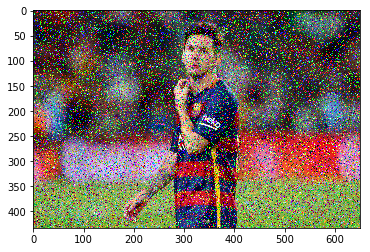

In [170]:
noise_white = np.random.rand(*image.shape) > 0.9
noise_black = np.random.rand(*image.shape) > 0.9
sp_image = np.copy(image)
sp_image[np.where(noise_white)] = 255
sp_image[np.where(noise_black)] = 0
sp_image = sp_image / 255.0
plt.imshow(sp_image)

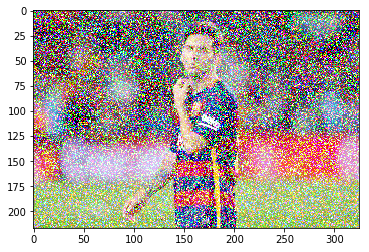

In [176]:
maxpool_image = maxpool(sp_image)
plt.imshow(maxpool_image)

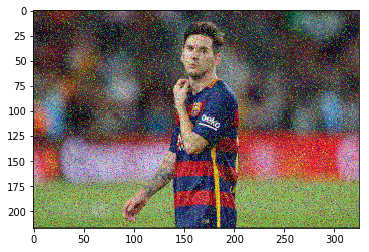

In [177]:
medianpool_image = medianpool(sp_image)
plt.imshow(medianpool_image)

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Лучше справляется medianpool, т.к. он сглаживает выбросы, а не берет максимальные значения как maxpool

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [62]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [63]:
for X, y in train_loader:
    X = Variable(X)
    y = Variable(y)
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [64]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [65]:
image_size = 28
channels = 1

In [11]:
# input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
class Conv1(nn.Module):
    def __init__(self, input_size, input_channels):
        super(Conv1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(input_channels, 8, (3, 3), padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (3, 3), padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(int(input_size * input_size / 4 * 16), 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [10]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [13]:
conv1 = Conv1(input_size=image_size, input_channels=channels)
print(conv1)

Conv1(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3136, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


Epoch 19... (Train/Test) NLL: 0.004/0.092	Accuracy: 0.999/0.986

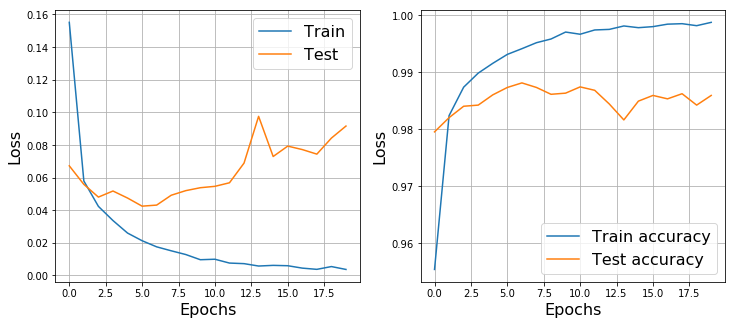

In [14]:
train(conv1, 20, 0.001)

In [15]:
# input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax
class Conv2(nn.Module):
    def __init__(self, input_size, input_channels):
        super(Conv2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(input_channels, 8, (3, 3), padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1),
                                        )
        self.linear_layers = nn.Sequential(nn.Linear(int(input_size * input_size / 4 * 32), 10), 
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [16]:
conv2 = Conv2(input_size=image_size, input_channels=channels)
print(conv2)

Conv2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


Epoch 19... (Train/Test) NLL: 0.010/0.083	Accuracy: 0.997/0.985

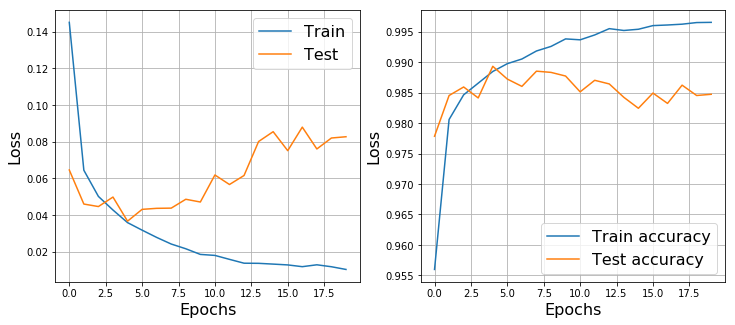

In [17]:
train(conv2, 20, 0.001)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [19]:
network = conv2

In [36]:
# search incorrectly classified objects in test data
X_wrong = []
correct_y = []
wrong_y = []
for X, y in test_loader:
    y_ppred = network(Variable(X))
    _, y_pred = torch.max(y_ppred, dim=1)
    y_pred = y_pred.data
    for i in range(len(y)):
        if y_pred[i] != y[i]:
            X_wrong.append(X[i])
            correct_y.append(y[i])
            wrong_y.append(y_pred[i])
print("{0} incorrectly classified objects".format(len(X_wrong)))

153 incorrectly classified objects


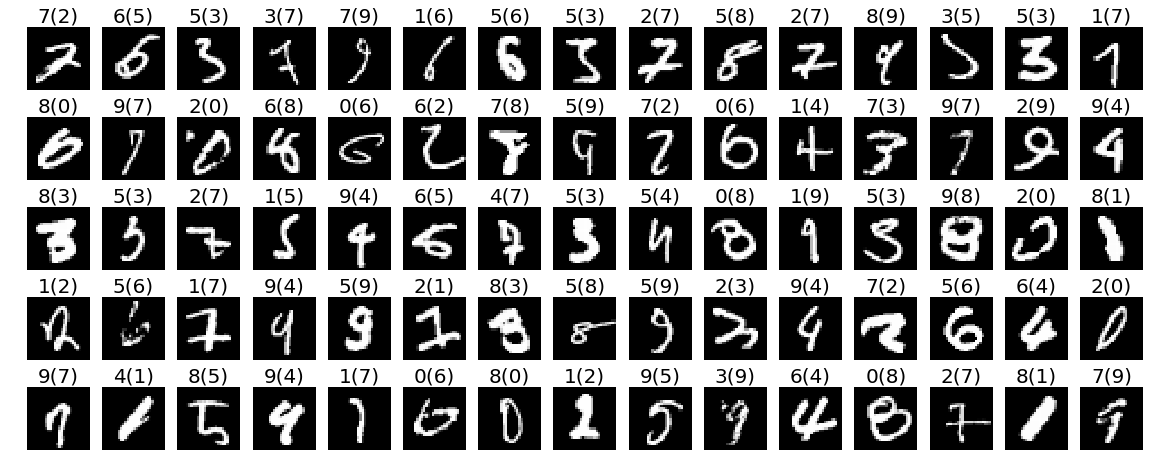

In [37]:
plt.figure(figsize=(20, 8))
for i in range(75):
    plt.subplot(5, 15, i+1)
    plt.imshow(X_wrong[i].numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(wrong_y[i], correct_y[i]), fontsize=20)
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [43]:
# dtype=torch.cuda.FloatTensor
# def train(network, epochs, learning_rate):
#     loss = nn.NLLLoss().cuda()
#     optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
#     train_loss_epochs = []
#     test_loss_epochs = []
#     train_accuracy_epochs = []
#     test_accuracy_epochs = []
#     try:
#         for epoch in range(epochs):
#             losses = []
#             accuracies = []
#             for X, y in train_loader:
#                 X = Variable(X).type(dtype)
#                 y = Variable(y).type(dtype)
#                 network.zero_grad()
#                 prediction = network(X)
#                 loss_batch = loss(prediction, y)
#                 losses.append(loss_batch.data[0])
#                 loss_batch.backward()
#                 optimizer.step()
#                 accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
#             train_loss_epochs.append(np.mean(losses))
#             train_accuracy_epochs.append(np.mean(accuracies))
#             losses = []
#             accuracies = []    
#             for X, y in test_loader:
#                 X = Variable(X).type(dtype)
#                 y = Variable(y).type(dtype)
#                 prediction = network(X)
#                 loss_batch = loss(prediction, y)
#                 losses.append(loss_batch.data[0])
#                 accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
#             test_loss_epochs.append(np.mean(losses))
#             test_accuracy_epochs.append(np.mean(accuracies))
#             sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
#                         epoch, train_loss_epochs[-1], test_loss_epochs[-1],
#                         train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
#     except KeyboardInterrupt:
#         pass
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(train_loss_epochs, label='Train')
#     plt.plot(test_loss_epochs, label='Test')
#     plt.xlabel('Epochs', fontsize=16)
#     plt.ylabel('Loss', fontsize=16)
#     plt.legend(loc=0, fontsize=16)
#     plt.grid('on')
#     plt.subplot(1, 2, 2)
#     plt.plot(train_accuracy_epochs, label='Train accuracy')
#     plt.plot(test_accuracy_epochs, label='Test accuracy')
#     plt.xlabel('Epochs', fontsize=16)
#     plt.ylabel('Loss', fontsize=16)
#     plt.legend(loc=0, fontsize=16)
#     plt.grid('on')
#     plt.show()

In [44]:
for X, y in train_loader:
    X = Variable(X).type(dtype)
    y = Variable(y).type(dtype)
    print(X.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [99]:
# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001


# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
cnn = CNN()
cnn.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))


Epoch [1/5], Iter [100/600] Loss: 0.4728
Epoch [1/5], Iter [200/600] Loss: 0.1720
Epoch [1/5], Iter [300/600] Loss: 0.1351
Epoch [1/5], Iter [400/600] Loss: 0.1846
Epoch [1/5], Iter [500/600] Loss: 0.0699
Epoch [1/5], Iter [600/600] Loss: 0.3913
Epoch [1/5], Iter [700/600] Loss: 0.1857
Epoch [1/5], Iter [800/600] Loss: 0.0965
Epoch [1/5], Iter [900/600] Loss: 0.0131
Epoch [1/5], Iter [1000/600] Loss: 0.0492
Epoch [1/5], Iter [1100/600] Loss: 0.0831
Epoch [1/5], Iter [1200/600] Loss: 0.1053
Epoch [1/5], Iter [1300/600] Loss: 0.0628
Epoch [1/5], Iter [1400/600] Loss: 0.0820
Epoch [1/5], Iter [1500/600] Loss: 0.0152
Epoch [1/5], Iter [1600/600] Loss: 0.1809
Epoch [1/5], Iter [1700/600] Loss: 0.2118
Epoch [1/5], Iter [1800/600] Loss: 0.0739
Epoch [2/5], Iter [100/600] Loss: 0.0269
Epoch [2/5], Iter [200/600] Loss: 0.1016
Epoch [2/5], Iter [300/600] Loss: 0.0171
Epoch [2/5], Iter [400/600] Loss: 0.0667
Epoch [2/5], Iter [500/600] Loss: 0.0042
Epoch [2/5], Iter [600/600] Loss: 0.0055
Epoch [

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: